In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import uproot
import root_to_pandas
import plot_stuff

In [2]:
sr = 25
times = np.arange(0,32,1, dtype=float)*sr

In [3]:
READ_PATHS = ['/Users/lukepolson/Documents/test_data/pulse_347848/',
              '/Users/lukepolson/Documents/test_data/pulse_347935/',
              '/Users/lukepolson/Documents/test_data/pulse_348061/']
DF_PATH = 'test_data/Cells/'
HISTO_PATH = 'test_data/'

In [4]:
COLUMNS = ['RunNumber','LBNumber',  'EventNumber','BCID','LArError','ncells', 'ECell',
            'TCell', 'EtaCell', 'PhiCell', 'LayerCell','ProvCell', 'QuaCell','GainCell',
            'HwidCell','ADC',]

7791 and 26323 are identification numbers of the cells.

In [5]:
HW_IDs = [61040]
DFS = [pd.DataFrame(columns=COLUMNS)]*len(HW_IDs)
DFS_DICT = dict(zip(HW_IDs, DFS))

# This is the Code that Works

In [6]:
first_time = False
if first_time:
    for READ_PATH in READ_PATHS:
        for (i,filename) in enumerate(os.listdir(READ_PATH)):
            if(i%30==0): print(i) 
            if filename.endswith(".pkl"):
                opened_df = pd.read_pickle(READ_PATH+filename)
                for HW_ID in HW_IDs:
                    DFS_DICT[HW_ID] = DFS_DICT[HW_ID].append(opened_df[opened_df['HwidCell']==HW_ID])
            del(opened_df)
            
else: 
    for (i,filename) in enumerate(os.listdir(DF_PATH)):
        if filename.endswith(".pkl"):
            opened_df = pd.read_pickle(DF_PATH+filename)
            hwid = int(filename[8:-4])
            DFS_DICT[hwid] = opened_df

In [7]:
def get_lag_time_col(row):
    if row['RunNumber'] == 347848:
        if (row['LBNumber']>=157 and row['LBNumber']<=189):
            return 0
        elif (row['LBNumber']>=190 and row['LBNumber']<=252):
            return 12.5
        elif (row['LBNumber']>=253 and row['LBNumber']<=284):
            return 6.25
        elif (row['LBNumber']>=285 and row['LBNumber']<=313):
            return 18.75
        elif (row['LBNumber']>=315 and row['LBNumber']<=347):
            return 3.125
        elif (row['LBNumber']>=349 and row['LBNumber']<=398):
            return 21.875
        elif (row['LBNumber']>=399 and row['LBNumber']<=420):
            return 12.5
        else:
            return 1000
        
    if row['RunNumber'] == 347935:
        if (row['LBNumber']>=1 and row['LBNumber']<=820):
            return 0
        elif (row['LBNumber']>=822 and row['LBNumber']<=852):
            return 12.5
        elif (row['LBNumber']>=854 and row['LBNumber']<=882):
            return 21.875
        elif (row['LBNumber']>=885 and row['LBNumber']<=910):
            return 3.125
        elif (row['LBNumber']>=912 and row['LBNumber']<=1013):
            return 18.75
        else:
            return 1000
        
    if row['RunNumber'] == 348061:
        if (row['LBNumber']>=1 and row['LBNumber']<=992):
            return 9.375
        elif (row['LBNumber']>=994):
            return 15.625
        else:
            return 1000
        
    
for key in DFS_DICT:
    DFS_DICT[key]['LagTime'] = DFS_DICT[key].apply(get_lag_time_col, axis=1)     

In [8]:
df = DFS_DICT[61040]

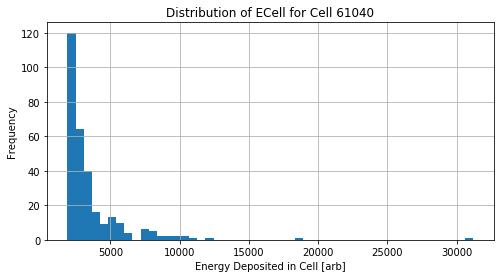

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
df['ECell'].hist(bins=50, ax=ax)
ax.set_ylabel('Frequency')
ax.set_xlabel('Energy Deposited in Cell [arb]')
ax.set_title('Distribution of ECell for Cell {}'.format(df.iloc[0]['HwidCell']))
plt.show()

In [10]:
ADC = df[df['ECell']>20000].iloc[0]['ADC']
EE = df[df['ECell']>20000].iloc[0]['ECell']
tt = times + df[df['ECell']>20000].iloc[0]['LagTime']

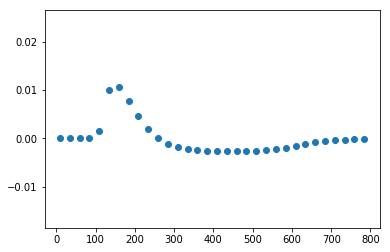

In [11]:
plt.scatter(tt, ADC/EE)

# How Does this Compare to Time Averaged Pulse?

In [12]:
file = uproot.open(HISTO_PATH+'LArPulseTest.root')
hwids = [int(key[5:-2].decode('utf-8')) for key in file.keys()]

histos = [file[key] for key in file.keys()]
histo_dfs = [root_to_pandas.hist_to_df(histo) for histo in histos]
histo_dfs = dict(zip(hwids, histo_dfs))

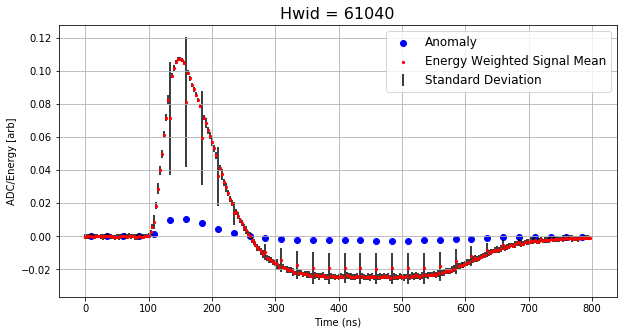

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(tt, ADC/EE, color='b', label='Anomaly')
plot_stuff.plotter_macro(ax, histo_dfs, hwids[2])

plt.savefig('test.png', dpi=200)
plt.show()